# Chapter 4

## Set Up

### Packages

In [5]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

### Defaults

In [24]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [7]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"

In [15]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

## 4.3 Gaussian model of height

In [16]:
# load data
howell = load_data(HOWELL_FILE, delimiter=";")

# get adult heights
height = howell.loc[howell["age"] >= 18, "height"].values

Plot the distribution

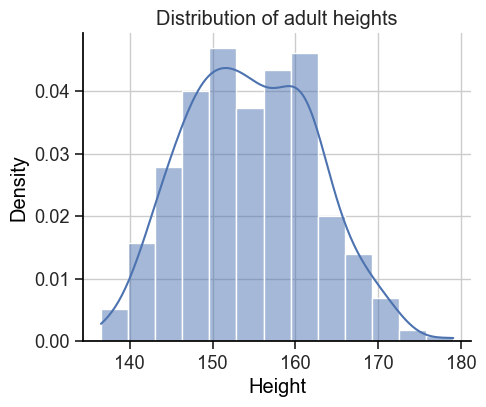

In [28]:
fig, ax = plt.subplots(figsize=(5, 4))

sns.histplot(height, kde=True, stat="density")

ax.set(
    xlabel="Height",
    title="Distribution of adult heights",
);

Set and plot priors

In [38]:
def plot_priors(priors):  
    n_priors = len(priors)

    ax_width = 6
    width = ax_width * n_priors

    fig, axs = plt.subplots(ncols=n_priors, figsize=(width, 4))

    for ax, (name, prior) in zip(axs, priors.items()):
        x_min, x_max = prior.ppf([0.001, 0.999])
        x_plot = np.linspace(x_min, x_max, 1000)
        y_plot = prior.pdf(x_plot)

        ax.plot(x_plot, y_plot)

        ax.set(
            ylabel="Density",
            title=name
        )

    fig.suptitle("Prior Density Functions")
    
    return fig, axs

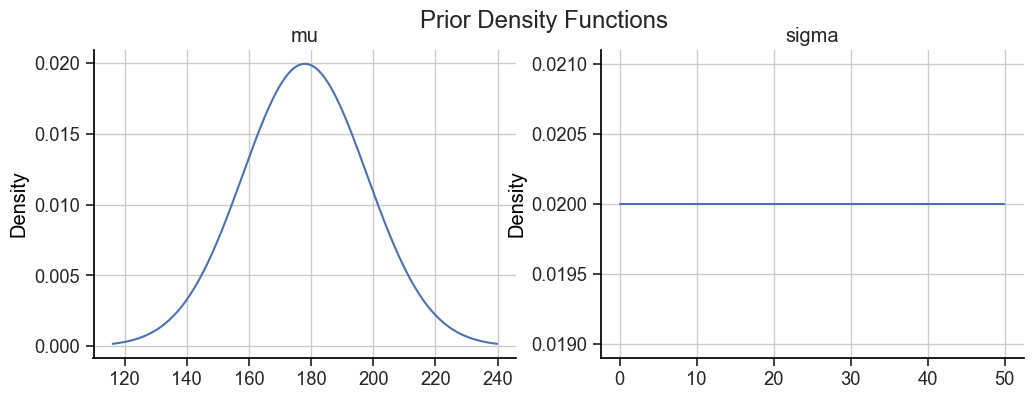

In [39]:
# priors
mu_prior = stats.norm(loc=178, scale=20)
sigma_prior = stats.uniform(0, 50)

priors = {
    "mu": mu_prior,
    "sigma": sigma_prior,
}
plot_priors(priors);

Plot the prior predictive

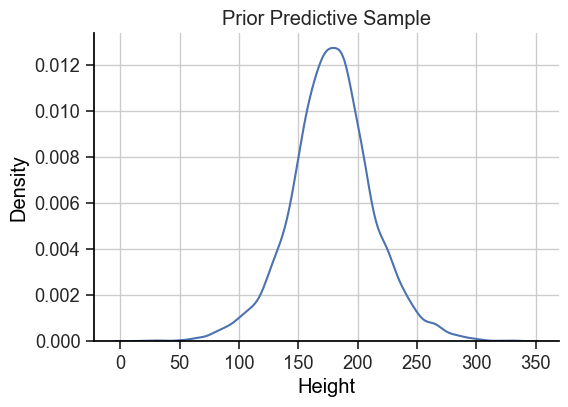

In [43]:
n_sample = 10000
mu_sample = mu_prior.rvs(n_sample)
sigma_sample = sigma_prior.rvs(n_sample)

prior_pred_sample = stats.norm.rvs(loc=mu_sample, scale=sigma_sample, size=n_sample)

# plot distribution
fig, ax = plt.subplots(figsize=(6, 4))

sns.kdeplot(prior_pred_sample, ax=ax)

ax.set(
    xlabel="Height",
    title="Prior Predictive Sample"
);

Grid approximation of the posterior

In [234]:
def calculate_height_posterior_with_grid_approximation(height, mu_range, mu_prior, sigma_range, sigma_prior):
    # take cross-product to get grids of pairs
    mu_grid, sigma_grid = np.meshgrid(mu_range, sigma_range)

    # get total log likelihood by taking sum of log likelihoods for each observation
    log_likelihood = np.array([
        stats.norm.logpdf(height[i], loc=mu_grid, scale=sigma_grid) for i in range(len(height))
    ]).sum(axis=0)

    # get log prior values at grid points
    mu_prior_log_val = mu_prior.logpdf(mu_grid)
    sigma_prior_log_val = sigma_prior.logpdf(sigma_grid)

    # update prior in log world
    log_posterior = log_likelihood + mu_prior_log_val + sigma_prior_log_val

    # get posterior
    posterior = np.exp(log_posterior - np.max(log_posterior))
    posterior /= posterior.sum()
    
    return posterior, mu_grid, sigma_grid

In [ ]:
mu_range = np.linspace(150, 169, 100)
sigma_range = np.linspace(7, 9, 100)

posterior, mu_grid, sigma_grid = calculate_height_posterior_with_grid_approximation(
    height,
    mu_range,
    mu_prior,
    sigma_range,
    sigma_prior
)

Plot joint distribution of posterior

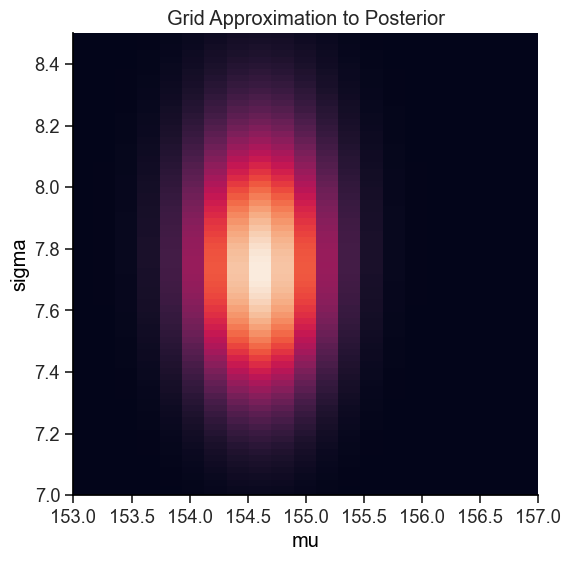

In [178]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.pcolormesh(mu_grid, sigma_grid, posterior);

ax.set(
    xlim=[153, 157],
    ylim=[7, 8.5],
    xlabel="mu",
    ylabel="sigma",
    title="Grid Approximation to Posterior",
);

Sample the posterior. We sample the index of the ravelled grid and use this to sample mu and sigma.

In [236]:
def sample_height_posterior(posterior):
    n_sample = np.prod(posterior.shape)
    grid_ravel_idx = np.arange(n_sample)

    samples_idx = np.random.choice(grid_ravel_idx, size=n_sample, p=posterior.ravel(), replace=True)

    mu_samples = mu_grid.ravel()[samples_idx]
    sigma_samples = sigma_grid.ravel()[samples_idx]
    
    return mu_samples, sigma_samples

In [237]:
mu_samples, sigma_samples = sample_height_posterior(posterior)

Plot the posterior sample

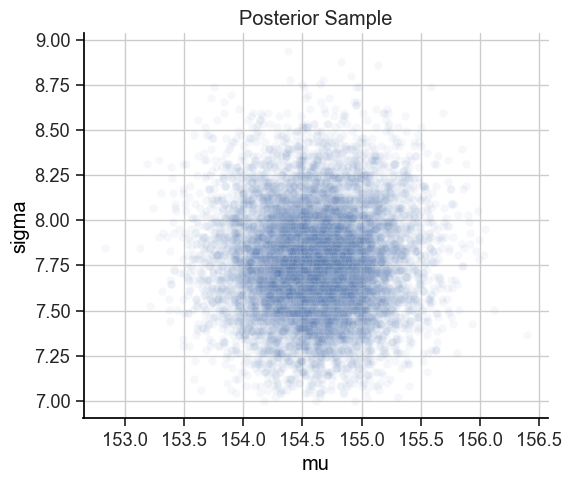

In [227]:
fig, ax = plt.subplots(figsize=(6, 5))

# add some jitter or the points are all on top of each other
mu_jitter_std = 0.1
mu_jitter = stats.norm.rvs(loc=0, scale=mu_jitter_std, size=len(mu_samples))

sns.scatterplot(
    x=mu_samples+mu_jitter,
    y=sigma_samples,
    alpha=0.05,
    ax=ax,
)

ax.set(
    xlabel="mu",
    ylabel="sigma",
    title="Posterior Sample",
);

We can also plot a joint density plot

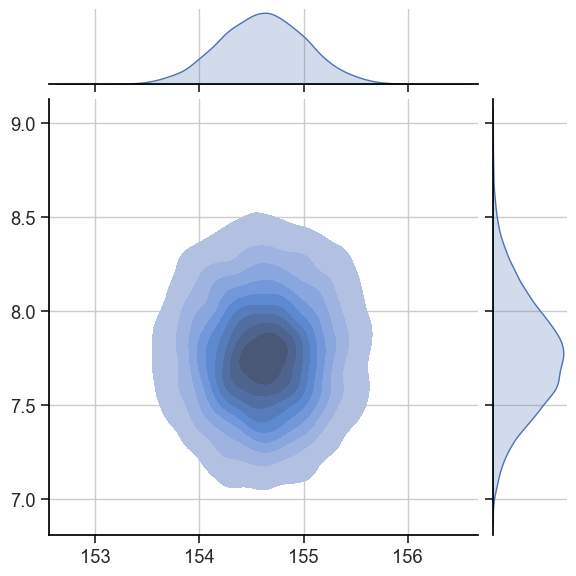

In [233]:
sns.jointplot(
    x=mu_samples+mu_jitter,
    y=sigma_samples,
    kind="kde",
    fill=True,
);

Try repeating the above with less data

array([160.655 , 146.685 , 147.955 , 156.845 , 158.115 , 160.02  ,
       153.035 , 167.64  , 158.115 , 148.59  , 147.955 , 171.1198,
       139.7   , 162.56  , 150.495 , 161.29  , 145.415 , 163.83  ,
       160.02  , 141.605 ])

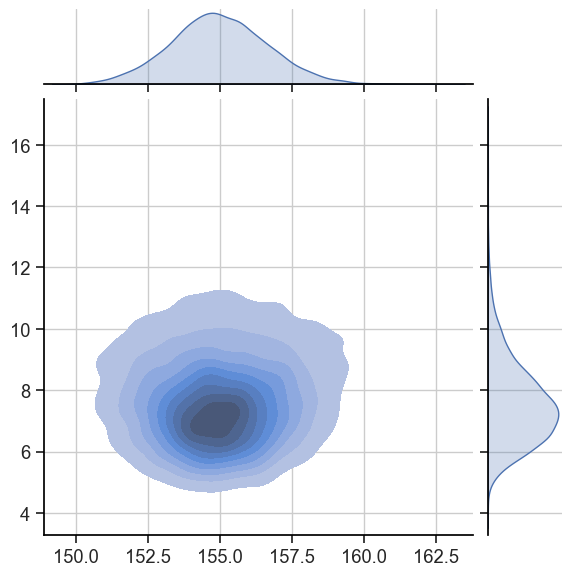

In [246]:
mu_range = np.linspace(150, 170, 100)
sigma_range = np.linspace(4, 20, 100)

height_sample = np.random.choice(height, size=20, replace=False)
posterior, mu_grid, sigma_grid = calculate_height_posterior_with_grid_approximation(
    height_sample,
    mu_range,
    mu_prior,
    sigma_range,
    sigma_prior
)

mu_samples, sigma_samples = sample_height_posterior(posterior)

sns.jointplot(
    x=mu_samples+mu_jitter,
    y=sigma_samples,
    kind="kde",
    fill=True,
);

The posterior is a lot wider and the parameter $\sigma$ is a lot less normal - it has a long tail.